In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import os
import re
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.filters import threshold_otsu

In [17]:
# Set the device for computation (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # Updated output size
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.pool(self.leaky_relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1)

In [30]:
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.4753, 0.4753, 0.4753])
])

In [20]:
# Create training dataset
# Set up the data directories
sets = ['Train_510','Train_1020','Train_2040','Train_4080','Train_8160','Train_10200']
for item in sets:
    data_dir = 'Test_Images'
    train_dir = os.path.join(data_dir, item)

    # Define a function to get the labels from the image filenames
    def get_label(filename):
        match = re.search(r'\d+\.?\d*', filename)
        if match:
            return float(match.group())
        else:
            return None

    # Define a list to store the image filenames and labels
    train_data = []

    # Iterate over the training images and add them to the list
    for filename in os.listdir(train_dir):
        label = get_label(filename)
        if label is not None:
            train_data.append([os.path.join(train_dir, filename), label])

    # Convert the list to a dataframe
    train_df = pd.DataFrame(train_data, columns=['filename', 'label'])

    # Save the dataframe to a CSV file
    train_df.to_csv(os.path.join(data_dir, item+'.csv'), index=False)

In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = self._load_data(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def _load_data(self, csv_file):
    # Load and preprocess data from the CSV file
    # Example: Assuming the CSV file has two columns representing image paths and labels
        data = []
        with open(csv_file, 'r') as file:
            lines = file.readlines()
            for line in lines[1:]:  # Skip the header row
                # Split the line by comma or any other appropriate delimiter
                image_path, label = line.strip().split(',')
                data.append((image_path, float(label)))  # Parse the label as float
        return data



In [22]:
# Example usage:
csv_file = 'Test_Images/Train_10200.csv'  # Replace with the path to your CSV file
image_folder = 'Test_Images/Train_10200'  # Replace with the path to your image folder


# Split the dataset into training and validation sets
dataset = CustomImageDataset(csv_file, image_folder, transform=transform)
# Define the sizes for your training, validation, and test sets
train_size = int(0.6 * len(dataset))  # 60% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 20% for test

# Use random_split to split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [23]:
# Define training constants
best_val_loss = float('inf')
best_learning_rate = None
num_epochs = 50
patience = 10
counter = 0
learning_rate = 0.001

train_losses = []
val_losses = []
epoch_numbers = []
item_train_losses = []  # List to store training losses for the current item
item_val_losses = []  # List to store validation losses for the current item

model = CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
threshold=0.5


In [24]:
for epoch in range(num_epochs):
    running_loss = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(device)  # Move inputs to the device
        labels = labels.to(device)  # Move labels to the device

        # Binarize inputs
        threshold = 0.5
        inputs = torch.where(inputs >= threshold, torch.ones_like(inputs), torch.zeros_like(inputs))
        inputs = inputs[:, :1, :, :]

        outputs = model(inputs)
        labels = labels.float()
        loss = criterion(outputs, labels)

        l1_lambda = 0.01
        l1_regularization = torch.tensor(0.).to(device)
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1).to(device)
        loss += l1_lambda * l1_regularization

        l2_lambda = 0.01
        l2_regularization = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, 2).to(device)
        loss += l2_lambda * l2_regularization

        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_samples = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

            # Binarize inputs
            threshold = 0.5
            inputs = torch.where(inputs >= threshold, torch.ones_like(inputs), torch.zeros_like(inputs))
            inputs = inputs[:, :1, :, :]
            
            outputs = model(inputs)
            labels = labels.float()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_samples += inputs.size(0)

        average_val_loss = val_loss / val_samples

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(average_val_loss)
        item_train_losses.append(running_loss / len(train_loader))
        item_val_losses.append(average_val_loss)

        epoch_numbers.append(epoch + 1)
        print('Epoch %d - Training Loss: %.6f - Validation Loss: %.6f - Learning Rate: %.3f' % (epoch + 1, running_loss / len(train_loader), average_val_loss, learning_rate))

    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        counter = 0
        torch.save(model.state_dict(), f'trained_model.pt')

    else:
        counter += 1
        if counter >= patience:
            print('No improvement in validation loss. Early stopping.')
            break

    print('Epoch %d completed.' % (epoch + 1))

    best_train_loss = min(item_train_losses)
    best_train_losses = best_train_loss

    best_val_loss = min(item_val_losses)
    best_val_losses = best_val_loss
    
    # Plotting the losses
    plt.plot(epoch_numbers, train_losses, label='Training Loss')
    plt.plot(epoch_numbers, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss_plot.jpeg', format='jpeg')
    plt.show()

KeyboardInterrupt: 

In [38]:
model = CNN()  # Replace YourModel with your actual model class
# Load the trained weights
model.load_state_dict(torch.load('trained_model_Train_10200_simple.pt'))

# Access the weights
weights = model.state_dict()

# Print the weights
for name, param in weights.items():
    print(f'Weights:\n{param}')

Weights:
tensor([[[[-2.8209e-01,  3.4767e-01,  2.0515e-01],
          [ 1.0837e-01,  3.2889e-01,  1.7211e-01],
          [ 2.2792e-01,  5.9606e-02,  3.4383e-01]]],


        [[[ 1.3385e-01,  5.5211e-02,  2.4519e-01],
          [ 1.7431e-01,  2.4784e-01, -2.5888e-01],
          [-2.3167e-01, -1.7581e-01, -1.8918e-01]]],


        [[[ 1.3005e-01,  1.5342e-01,  2.5648e-02],
          [ 1.7709e-01,  2.3020e-01, -1.6799e-01],
          [ 2.1350e-01, -6.0211e-02, -1.1386e-01]]],


        [[[ 2.7104e-01,  7.3714e-03, -2.1884e-01],
          [ 2.3789e-01,  9.3384e-02,  1.6096e-01],
          [ 2.3756e-01,  2.4623e-01,  3.0185e-01]]],


        [[[ 1.9061e-01,  8.5969e-02,  1.8811e-01],
          [ 5.1347e-02, -1.6476e-01,  2.6961e-01],
          [-1.1583e-01, -3.0115e-01,  2.7773e-01]]],


        [[[ 6.3567e-02, -8.1822e-02,  2.6744e-01],
          [ 7.2284e-02,  1.8134e-01, -2.9371e-01],
          [-2.3876e-01, -1.7037e-01,  1.0199e-01]]],


        [[[ 1.6411e-05, -1.0880e-04,  4.6966e-05]

In [63]:
# Create empty lists for the data
predicted_values_list = []
labels_list = []
difference_list = []

# Iterate over the test data
for sample in test_loader:
    # Move the input data to the device
    inputs = sample[0].to(device)  # The input images are the first element in each sample
    inputs = torch.where(inputs >= threshold, torch.ones_like(inputs), torch.zeros_like(inputs))
    inputs = inputs[:, :1, :, :]
    labels = sample[1].to(device)  # The labels are the second element in each sample

    # Forward pass through the model
    with torch.no_grad():
        predicted_values = model(inputs).detach().numpy().tolist()

    # Get the predicted labels
    predicted_labels = outputs.detach().numpy().tolist()  # Assuming the model output is a single scalar value

    # Extend the lists
    predicted_values_list.extend(predicted_values)
    labels_list.extend(labels.detach().numpy().tolist())

# Create a pandas DataFrame
data = {
    'Predicted Value': predicted_values_list,
    'Label': labels_list,
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

      Predicted Value  Label
0           57.246223   57.0
1           40.958118   42.0
2           57.353603   58.0
3           50.349815   50.0
4           60.771076   61.0
...               ...    ...
2035        39.039043   39.0
2036        67.206047   67.0
2037        76.021622   77.0
2038        51.842476   52.0
2039        43.831764   44.0

[2040 rows x 2 columns]


In [67]:
Difference = []
# Substract Predicted_value from label
for predicted_value, label in zip(data['Predicted Value'], data['Label']):
    Difference.append(predicted_value - label)

# Add new column
data['Difference'] = Difference

df = pd.DataFrame(data)

# Print the DataFrame
print(df)

      Predicted Value  Label  Difference
0           57.246223   57.0    0.246223
1           40.958118   42.0   -1.041882
2           57.353603   58.0   -0.646397
3           50.349815   50.0    0.349815
4           60.771076   61.0   -0.228924
...               ...    ...         ...
2035        39.039043   39.0    0.039043
2036        67.206047   67.0    0.206047
2037        76.021622   77.0   -0.978378
2038        51.842476   52.0   -0.157524
2039        43.831764   44.0   -0.168236

[2040 rows x 3 columns]


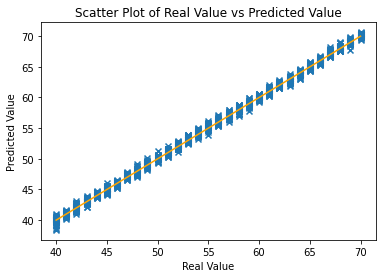

In [73]:
# Filter the predictions_test_df to include only the range 40-70 real values $$$
filtered_predictions_test_df = df[(df['Label'] >= 40) & (df['Label'] <= 70)]

# Create a scatter plot
plt.scatter(filtered_predictions_test_df['Label'], filtered_predictions_test_df['Predicted Value'], marker='x')

# Plot the line y = x
x = np.linspace(filtered_predictions_test_df['Label'].min(), filtered_predictions_test_df['Label'].max(), 100)
plt.plot(x, x, color='orange')

# Set plot labels and title
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Real Value vs Predicted Value')

# Save plot
plt.savefig('Scatter_real_vs_pred.jpeg', format='jpeg')

# Display the plot
plt.show()

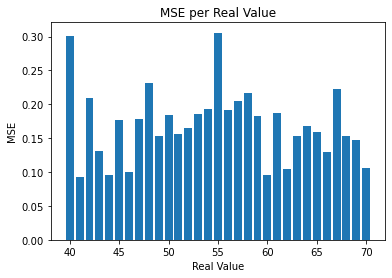

In [74]:
# Calculate the MSE per real value
mse_per_real_value_test = filtered_predictions_test_df.groupby('Label')['Difference'].apply(lambda x: mean_squared_error(x, np.zeros_like(x)))

# Plot the MSE per real value
plt.bar(mse_per_real_value_test.index, mse_per_real_value_test)
plt.xlabel('Real Value')
plt.ylabel('MSE')
plt.title('MSE per Real Value')

# Save plot
plt.savefig('MSE_per_real.jpeg', format='jpeg')

# Show the plot
plt.show()